# Section 4: Deep Learning
## Project: Male vs Female Eye Classification
- Dataset: https://www.kaggle.com/pavelbiz/eyes-rtte

### 개요
여성과 남성의 눈은 그 형태는 매우 비슷하지만 분명 구분되는 특징이 존재한다.   
정확히 어떻게 하는지는 모르지만 우리 사람은 높은 정확도로 구분해내곤 한다.  
인공 신경망을 이용하여 컴퓨터에게 눈 이미지를 성별에 맞게 분류시켜보자.
### 응용분야
얼굴 인식, 보안(페이스 아이디, 홍채 인식)

---

## 목차:
- 랜덤 시드 고정
- 데이터셋 준비
- 데이터 불러오기 및 시각화
- 모델 만들기 및 학습 (ANN, CNN, MobileNet)
- 테스트셋 비교
- 실데이터 예측해보기
- 결론

## Imports

In [1]:
import numpy as np
import tensorflow as tf

import os
import shutil
import random
import glob

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

## 0. 랜덤 시드 고정 (Optional)

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 1. 데이터셋 준비
- 데이터셋을 다운로드하여 압축을 풀면 하위폴더로 `/femaleyes`와 `/maleeyes`라는 폴더가 나온다.
- 각 폴더안에는 여성과 남성의 눈 이미지가 각각 5~6천개 정도 들어있다.
- 이 데이터를 밸런스를 맞추어 train, val, test 세트로 폴더를 나누고 이동한다.

In [3]:
os.chdir('data/')
if os.path.isdir('train/female') is False:
  os.makedirs('train/female')
  os.makedirs('train/male')
  os.makedirs('valid/female')
  os.makedirs('valid/male')
  os.makedirs('test/female')
  os.makedirs('test/male')

  for i in random.sample(glob.glob('femaleeyes/*'), 4000):
    shutil.move(i, 'train/female')      
  for i in random.sample(glob.glob('maleeyes/*'), 4000):
    shutil.move(i, 'train/male')
  for i in random.sample(glob.glob('femaleeyes/*'), 500):
    shutil.move(i, 'valid/female')        
  for i in random.sample(glob.glob('maleeyes/*'), 500):
    shutil.move(i, 'valid/male')
  for i in random.sample(glob.glob('femaleeyes/*'), 250):
    shutil.move(i, 'test/female')      
  for i in random.sample(glob.glob('maleeyes/*'), 250):
    shutil.move(i, 'test/male')
else:
  print('dataset already organized! skipping...')

os.chdir('../')

## 2. 데이터 불러오기 및 시각화
- 정돈한 데이터를 학습에 사용할 수 있게 알맞은 형태(`Sequence`)로 불러옵니다.
- 불러온 데이터를 `plot`하여 레이블과 함께 확인합니다.

In [4]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

In [5]:
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path, target_size=(224, 224))
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(224, 224))
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_path, target_size=(224, 224), shuffle=False)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [6]:
imgs, labels = next(train_batches)

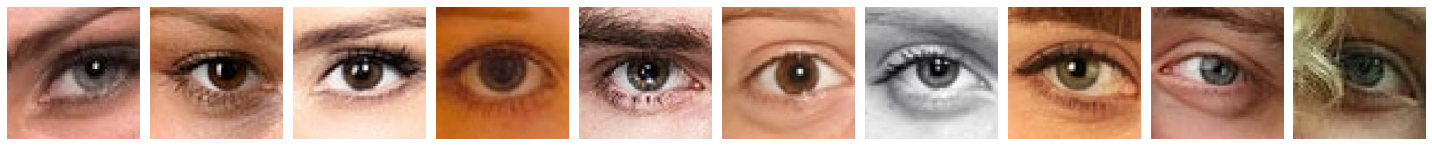

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr[:10], axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(imgs)
print(labels[:10])

In [8]:
imgs[0].shape

(224, 224, 3)

## 3-1. 기본 인공 신경망 모델 (ANN)

In [9]:
model_1 = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9633856   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 9,638,146
Trainable params: 9,638,146
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history_1 = model_1.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
250/250 [==============================] - 36s 142ms/step - loss: 1.3519 - accuracy: 0.6727 - val_loss: 0.4484 - val_accuracy: 0.7970
Epoch 2/10
250/250 [==============================] - 11s 42ms/step - loss: 0.6866 - accuracy: 0.7254 - val_loss: 0.5035 - val_accuracy: 0.7520
Epoch 3/10
250/250 [==============================] - 10s 42ms/step - loss: 0.4954 - accuracy: 0.7768 - val_loss: 0.3752 - val_accuracy: 0.8280
Epoch 4/10
250/250 [==============================] - 10s 42ms/step - loss: 0.5183 - accuracy: 0.7688 - val_loss: 0.4085 - val_accuracy: 0.8080
Epoch 5/10
250/250 [==============================] - 10s 41ms/step - loss: 0.5101 - accuracy: 0.7744 - val_loss: 0.6286 - val_accuracy: 0.6870
Epoch 6/10
250/250 [==============================] - 10s 42ms/step - loss: 0.4399 - accuracy: 0.8058 - val_loss: 0.3524 - val_accuracy: 0.8500
Epoch 7/10
250/250 [==============================] - 10s 41ms/step - loss: 0.4376 - accuracy: 0.8083 - val_loss: 0.3281 - val_accuracy

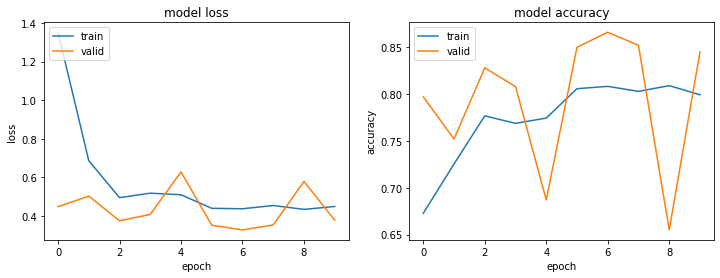

In [12]:
def plot_history(history):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

plot_history(history_1)

## 3-2. 합성곱 신경망 모델 (CNN)

In [13]:
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [14]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history_2 = model_2.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
250/250 [==============================] - 114s 455ms/step - loss: 0.5492 - accuracy: 0.7425 - val_loss: 0.3310 - val_accuracy: 0.8530
Epoch 2/10
250/250 [==============================] - 114s 456ms/step - loss: 0.3569 - accuracy: 0.8491 - val_loss: 0.3050 - val_accuracy: 0.8720
Epoch 3/10
250/250 [==============================] - 114s 456ms/step - loss: 0.3476 - accuracy: 0.8506 - val_loss: 0.3716 - val_accuracy: 0.8290
Epoch 4/10
250/250 [==============================] - 114s 455ms/step - loss: 0.3196 - accuracy: 0.8695 - val_loss: 0.2734 - val_accuracy: 0.8810
Epoch 5/10
250/250 [==============================] - 114s 455ms/step - loss: 0.3250 - accuracy: 0.8644 - val_loss: 0.2898 - val_accuracy: 0.8910
Epoch 6/10
250/250 [==============================] - 114s 456ms/step - loss: 0.2820 - accuracy: 0.8841 - val_loss: 0.2831 - val_accuracy: 0.8820
Epoch 7/10
250/250 [==============================] - 116s 463ms/step - loss: 0.2482 - accuracy: 0.8970 - val_loss: 0.3093 -

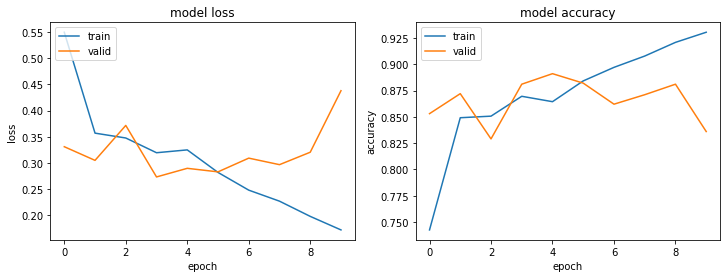

In [16]:
plot_history(history_2)

## 3-3. 외부모델을 전이학습 (MobileNet)
참고로 MobileNet도 내부적으로는 **CNN 구조**를 사용한다.

In [17]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [18]:
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)

model_3 = Model(inputs=mobile.input, outputs=output)

for layer in model_3.layers[:-23]:
    layer.trainable = False

model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [19]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history_3 = model_3.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
250/250 [==============================] - 129s 510ms/step - loss: 0.2269 - accuracy: 0.9172 - val_loss: 0.2769 - val_accuracy: 0.8940
Epoch 2/10
250/250 [==============================] - 127s 507ms/step - loss: 0.1158 - accuracy: 0.9545 - val_loss: 0.2097 - val_accuracy: 0.9160
Epoch 3/10
250/250 [==============================] - 123s 492ms/step - loss: 0.0711 - accuracy: 0.9726 - val_loss: 0.1641 - val_accuracy: 0.9360
Epoch 4/10
250/250 [==============================] - 124s 497ms/step - loss: 0.0603 - accuracy: 0.9769 - val_loss: 0.1874 - val_accuracy: 0.9270
Epoch 5/10
250/250 [==============================] - 125s 499ms/step - loss: 0.0521 - accuracy: 0.9815 - val_loss: 0.2922 - val_accuracy: 0.8990
Epoch 6/10
250/250 [==============================] - 125s 500ms/step - loss: 0.0449 - accuracy: 0.9829 - val_loss: 0.4092 - val_accuracy: 0.8640
Epoch 7/10
250/250 [==============================] - 128s 514ms/step - loss: 0.0238 - accuracy: 0.9905 - val_loss: 0.2640 -

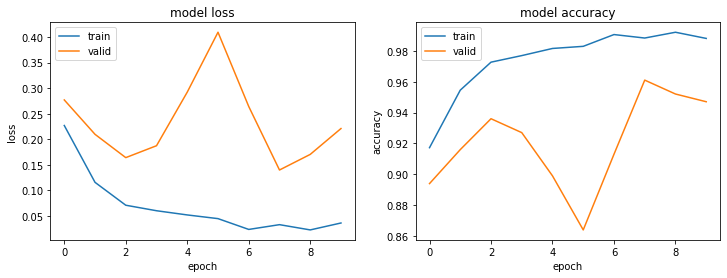

In [21]:
plot_history(history_3)

## 4. 테스트셋 비교

In [22]:
result_1 = model_1.evaluate(test_batches)

16/16 [==============================] - 2s 105ms/step - loss: 0.3679 - accuracy: 0.8540


In [23]:
result_2 = model_2.evaluate(test_batches)

16/16 [==============================] - 2s 121ms/step - loss: 0.4171 - accuracy: 0.8440


In [24]:
result_3 = model_3.evaluate(test_batches)

16/16 [==============================] - 5s 282ms/step - loss: 0.2379 - accuracy: 0.9400


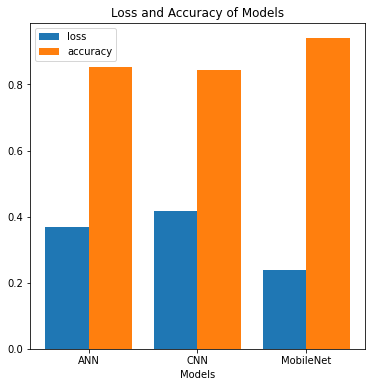

In [25]:
plt.rcParams["figure.figsize"] = (6,6)
X = ['ANN', 'CNN', 'MobileNet']
loss = [result[0] for result in (result_1, result_2, result_3)]
acc = [result[1] for result in (result_1, result_2, result_3)]
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, loss, 0.4, label = 'loss')
plt.bar(X_axis + 0.2, acc, 0.4, label = 'accuracy')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.title("Loss and Accuracy of Models")
plt.legend()
plt.show()

## 5. 실데이터 예측
다운로드한 데이터셋에서 분리한 테스트 데이터말고 실제로 직접 구한 사진을 예측해보자

In [60]:
def predict_gender(img):
    """이미지를 전달하면 모델 3개의 예측결과를 반환하는 함수"""
    image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224, 3))
    plt.rcParams["figure.figsize"] = (3,3)
    plt.imshow(image);plt.axis('off');plt.show()
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    for num, model in enumerate([model_1, model_2, model_3]):
        predictions = model.predict(input_arr)
        result = "여성" if np.argmax(predictions, axis=-1) == [0] else "남성"
        print(f"model_{num+1}: *{result}* (확률: {predictions[0]})")

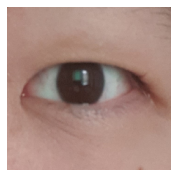

model_1: *여성* (확률: [1. 0.])
model_2: *남성* (확률: [0. 1.])
model_3: *남성* (확률: [0.08260761 0.91739243])


In [72]:
predict_gender('myeye.jpg')

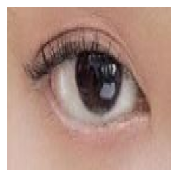

model_1: *여성* (확률: [1.0000000e+00 1.7580294e-23])
model_2: *여성* (확률: [1. 0.])
model_3: *여성* (확률: [0.9586779  0.04132206])


In [73]:
predict_gender('jennyeye.jpg')

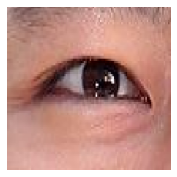

model_1: *여성* (확률: [1.0000000e+00 1.3903762e-23])
model_2: *여성* (확률: [1. 0.])
model_3: *남성* (확률: [0.20569351 0.79430646])


In [74]:
predict_gender('joinsungeye.JPG')

## 6. 결론
- ANN = CNN < MobileNet 순으로 성능이 좋아진다. (ANN과 CNN은 얼추 비슷)
- 하지만 CNN과 MobileNet은 에폭당 학습시간이 열배가량 늘어난다.
- 세 모델 모두 훈련을 거듭할수록 훈련 정확도는 높아지나 검증 정확도는 일정구간에서 오르락 내리락하며 나아지지 않는다.
- 서양 사람의 눈 이미지로 훈련해서 그런지 동양인 이미지는 잘 구분해내지 못하는 것 같다.